In [1]:
from qm import QuantumMachinesManager, QopCaps
from qm.qua import *
from configuration import *

2025-08-20 10:07:27,957 - qm - INFO     - Starting session: 5ded0118-4c19-49ae-a508-a6bb1f07c2f2


In [ ]:
qop_ip = "127.0.0.1" 
cluster_name = None 
qmm = QuantumMachinesManager(host=qop_ip,port=None, cluster_name=cluster_name)
print(f"config seperation: {qmm.capabilities.supports(QopCaps.config_v2)}")

2025-08-20 10:07:31,882 - qm - INFO     - Performing health check
2025-08-20 10:07:32,269 - qm - INFO     - Cluster healthcheck completed successfully.
config seperation: True


In [3]:
resonator = "rr1"
n_avg = 100  # The number of averages

with program() as raw_trace_prog:
    n = declare(int)  # QUA variable for the averaging loop
    adc_st = declare_stream(adc_trace=True)  # The stream to store the raw ADC trace

    with for_(n, 0, n < n_avg, n + 1):
        # Reset the phase of the digital oscillator associated to the resonator element. Needed to average the cosine signal.
        reset_if_phase(resonator)
        # Sends the readout pulse and stores the raw ADC traces in the stream called "adc_st"
        measure("readout", resonator, adc_stream = adc_st)
        # Wait for the resonator to deplete
        wait(depletion_time * u.ns, resonator)

    with stream_processing():
        # Will save average:
        adc_st.input1().average().save("adc")
        # Will save only last run:
        adc_st.input1().save("adc_single_run")



In [4]:
# Open a quantum machine to execute the QUA program
qm = qmm.open_qm(full_config,close_other_machines=True)
# Send the QUA program to the OPX, which compiles and executes it
job = qm.execute(raw_trace_prog)
# Creates a result handle to fetch data from the OPX
res_handles = job.result_handles
# Waits (blocks the Python console) until all results have been acquired
results = res_handles.fetch_results(wait_until_done=True, timeout=60,stream_names=["adc","adc_single_run"])
# Fetch the raw ADC traces and convert them into Volts
adc = u.raw2volts(results.get("adc")[0][0])
adc_single_run = u.raw2volts(results.get("adc_single_run")[0][0])


c:\Users\JackChao\miniconda3\envs\qop350\Lib\site-packages\qm\program\_qua_config_schema.py:1894: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


2025-08-20 10:07:33,435 - qm - INFO     - Clearing queue
2025-08-20 10:07:34,225 - qm - INFO     - Adding program to queue.
2025-08-20 10:07:35,660 - qm - INFO     - Job 4ced1668-7420-4f68-935d-e522c71bb7c2 is done


delay = 292.0ns


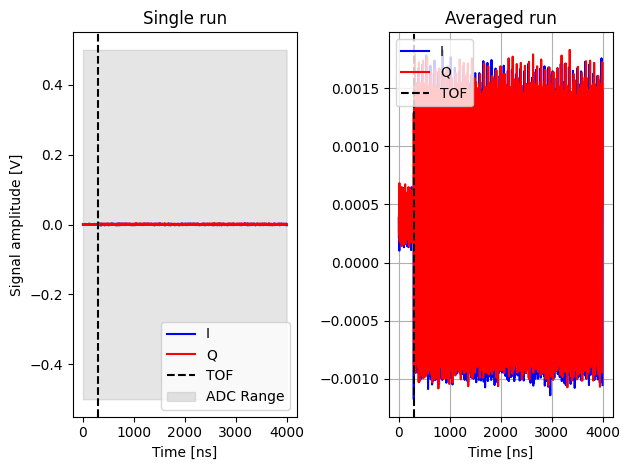

In [5]:
# find delay
delay = find_delay(adc)
# Plot data
fig = plot_adc(adc,adc_single_run,delay)


In [6]:
logical_config["elements"]['rr1']["time_of_flight"] += int(delay)

job2 = qm.execute(raw_trace_prog,config=logical_config)
# Creates a result handle to fetch data from the OPX
res_handles = job2.result_handles
# Waits (blocks the Python console) until all results have been acquired
results = res_handles.fetch_results(wait_until_done=True, timeout=60,stream_names=["adc","adc_single_run"])
# Fetch the raw ADC traces and convert them into Volts
adc = u.raw2volts(results.get("adc")[0][0])
adc_single_run = u.raw2volts(results.get("adc_single_run")[0][0])

2025-08-20 10:07:39,173 - qm - INFO     - Clearing queue
2025-08-20 10:07:39,773 - qm - INFO     - Adding program to queue.
2025-08-20 10:07:41,184 - qm - INFO     - Job 704e4cd8-a979-43b3-a897-bb7a6f054c5c is done


delay = 0.0ns


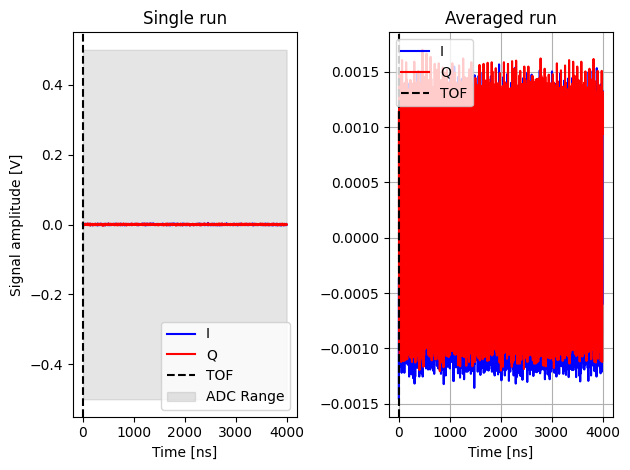

In [7]:
# find delay
delay = find_delay(adc)
# Plot data
fig = plot_adc(adc,adc_single_run,delay)

In [8]:
full_config = controller_config | logical_config # store your config with calibrated values
qm.close()

True